In [7]:
# Import necessary packages
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

import h5py
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from torchvision import transforms, models

device = "cuda" if torch.cuda.is_available() else "cpu"
device

In [8]:
# Load training dataset
with h5py.File("C:/Users/jieta/Downloads/train_catvnoncat.h5", "r") as f:
    X_train_raw = np.array(f["train_set_x"])     # (209, 64, 64, 3)
    Y_train_raw = np.array(f["train_set_y"])     # (209,)
    classes = np.array(f["list_classes"])    # ("non-cat", "cat")

# Load test dataset
with h5py.File("C:/Users/jieta/Downloads/test_catvnoncat.h5", "r") as f:
    X_test_raw = np.array(f["test_set_x"])       # (50, 64, 64, 3)
    Y_test_raw = np.array(f["test_set_y"])       # (50,)

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std =[0.229, 0.224, 0.225])
])

class CatDataset(Dataset):
    def __init__(self, X, Y, transform=None):
        self.X = X
        self.Y = Y
        self.transform = transform

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        image = self.X[idx]      # shape: (64, 64, 3)
        label = float(self.Y[idx])

        # HWC → numpy array for transform
        if self.transform:
            image = self.transform(image)

        return image, label

In [9]:
# NEW TRAIN/TEST SPLIT
split = 160 + 3   # ID ends with 3

X_train2 = X_train_raw[:split]
Y_train2 = Y_train_raw[:split]

X_test2 = X_train_raw[split:]
Y_test2 = Y_train_raw[split:]

train2_dataset = CatDataset(X_train2, Y_train2, transform)
test2_dataset  = CatDataset(X_test2,  Y_test2,  transform)

train2_loader = DataLoader(train2_dataset, batch_size=8, shuffle=True)
test2_loader  = DataLoader(test2_dataset,  batch_size=8)


In [10]:
model2 = models.resnet18(pretrained=True)
model2.fc = nn.Linear(model2.fc.in_features, 1)
model2 = model2.to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model2.parameters(), lr=1e-5)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=1e-6)
num_epochs = 5

def train_model(model, train_loader, optimizer, scheduler, criterion, num_epochs, device):
    model.train()

    for epoch in range(num_epochs):
        running_loss = 0.0

        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.float().to(device).view(-1, 1)

            optimizer.zero_grad()

            outputs = model(images)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        scheduler.step()

        print(f"Epoch [{epoch+1}/{num_epochs}] Loss: {running_loss/len(train_loader):.4f}")

    print("Training complete.")

train_model(model2, train2_loader, optimizer, scheduler, criterion, num_epochs, device)

Epoch [1/5] Loss: 0.6262
Epoch [2/5] Loss: 0.4172
Epoch [3/5] Loss: 0.3025
Epoch [4/5] Loss: 0.2593
Epoch [5/5] Loss: 0.2206
Training complete.


In [11]:
def evaluate_model(model, loader):
    model.eval()
    preds, trues = [], []

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)

            outputs = model(images)
            probs = torch.sigmoid(outputs).cpu().numpy()
            predictions = (probs > 0.5).astype(int).flatten()

            preds.extend(predictions)
            trues.extend(labels.numpy())

    accuracy = np.mean(np.array(preds) == np.array(trues))
    return accuracy, preds, trues

train2_acc, train2_preds, train2_trues = evaluate_model(model2, train2_loader)
test2_acc,  test2_preds,  test2_trues  = evaluate_model(model2, test2_loader)

print("Training Accuracy (modified):", train2_acc)
print("Test Accuracy (modified):", test2_acc)


Training Accuracy (modified): 1.0
Test Accuracy (modified): 0.9565217391304348


Training Accuracy (modified): 0.9938650306748467
Test Accuracy (modified): 0.9565217391304348
Misclassified indices (modified): [22, 34]


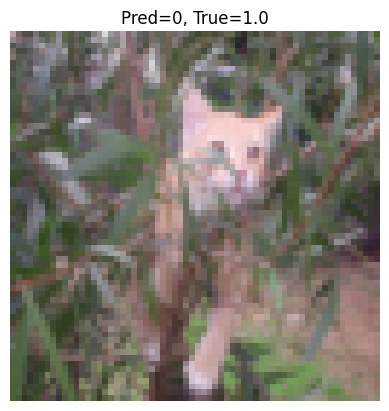

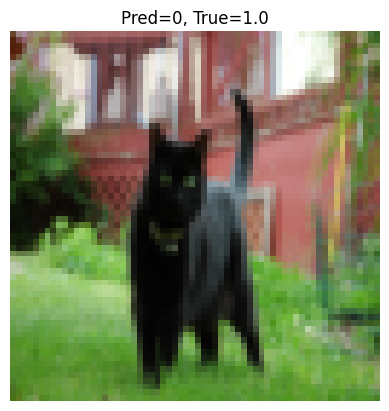

In [12]:
train2_acc, train2_preds, train2_trues = evaluate_model(model2, train2_loader)
test2_acc,  test2_preds,  test2_trues  = evaluate_model(model2, test2_loader)

print("Training Accuracy (modified):", train2_acc)
print("Test Accuracy (modified):", test2_acc)

mis_idx2 = [i for i in range(len(test2_preds)) if test2_preds[i] != test2_trues[i]]
print("Misclassified indices (modified):", mis_idx2)

def show_misclassified(indices, X_raw, preds, trues):
    for i in indices[:4]:
        plt.imshow(X_raw[i])
        plt.title(f"Pred={preds[i]}, True={trues[i]}")
        plt.axis('off')
        plt.show()

show_misclassified(mis_idx2, X_test2, test2_preds, test2_trues)
